# Continuation from v1 and 2

- Taking out some of the brainstorming, and leaving final results
- Adding a model + cross validation
- if there's a v4, I will add gridsearch to the model and see if I get better accuracy

# Instructions

Predict the sale price of a particular piece of heavy equipment at auction based on it's usage, equipment type, and configuration. The data is sourced from auction result postings and includes information on usage and equipment configurations.

https://github.com/gSchool/ds-case-study-linear-models/tree/master/predict_auction_price

note that there is a function in scikit-learn to do the error you need to evaluate this model.  For any method that takes 'scoring' as a keyword, pass in 'neg_mean_squared_log_error' as a string. That is, set scoring='neg_mean_squared_log_error'. The method will then compute the square of the rmslog error needed to evaluate your model for Task #20

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

label=LabelEncoder()

%matplotlib inline

### [1] Importing both data sets, putting it into Pandas DF 

In [2]:
dftrain = pd.read_csv('train.csv')
dftest = pd.read_csv('test.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (13,39,40,41) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(dftrain.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 53 columns):
SalesID                     401125 non-null int64
SalePrice                   401125 non-null int64
MachineID                   401125 non-null int64
ModelID                     401125 non-null int64
datasource                  401125 non-null int64
auctioneerID                380989 non-null float64
YearMade                    401125 non-null int64
MachineHoursCurrentMeter    142765 non-null float64
UsageBand                   69639 non-null object
saledate                    401125 non-null object
fiModelDesc                 401125 non-null object
fiBaseModel                 401125 non-null object
fiSecondaryDesc             263934 non-null object
fiModelSeries               56908 non-null object
fiModelDescriptor           71919 non-null object
ProductSize                 190350 non-null object
fiProductClassDesc          401125 non-null object
state                       4

### [2] figuring out how many missing values per column we have 

In [4]:
null_results_df = pd.DataFrame(np.logical_not(dftrain.isnull()).sum() / dftrain.shape[0], columns = ['ratio'])
nullrsorted = null_results_df.sort_values(['ratio'])
#null_results_df.sort_values(['ratio'])
#null_results_df.keys()

nullrsorted

,ratio
Engine_Horsepower,0.062871
Blade_Width,0.062871
Blade_Extension,0.062871
Pushblock,0.062871
Tip_Control,0.062871
Enclosure_Type,0.062871
Scarifier,0.062898
Hydraulics_Flow,0.108101
Grouser_Tracks,0.108101
Coupler_System,0.108340


#### (a) getting rid of columns where ratio < 80% (of data) 

In [5]:
delete_columns = []
row_num = nullrsorted.shape[0]

for i in range(row_num):
    n_column = nullrsorted.iloc[i]
    if n_column.ratio < 0.80:
        delete_columns.append(n_column.name)

delete_columns

['Engine_Horsepower',
 'Blade_Width',
 'Blade_Extension',
 'Pushblock',
 'Tip_Control',
 'Enclosure_Type',
 'Scarifier',
 'Hydraulics_Flow',
 'Grouser_Tracks',
 'Coupler_System',
 'fiModelSeries',
 'Steering_Controls',
 'Differential_Type',
 'UsageBand',
 'fiModelDescriptor',
 'Backhoe_Mounting',
 'Turbocharged',
 'Stick',
 'Pad_Type',
 'Blade_Type',
 'Travel_Controls',
 'Tire_Size',
 'Track_Type',
 'Grouser_Type',
 'Stick_Length',
 'Pattern_Changer',
 'Thumb',
 'Undercarriage_Pad_Width',
 'Ripper',
 'Drive_System',
 'MachineHoursCurrentMeter',
 'Ride_Control',
 'Transmission',
 'ProductSize',
 'Forks',
 'Coupler',
 'fiSecondaryDesc',
 'Hydraulics']

In [6]:
dftrain.drop(delete_columns,axis=1,inplace=True)

### Yay! took out the columns of < 80% of data
### [3] Now we explore our new dataset

In [7]:
dftrain.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,saledate,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Enclosure
0,1139246,66000,999089,3157,121,3.0,2004,11/16/06 0:00,521D,521,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,EROPS w AC
1,1139248,57000,117657,77,121,3.0,1996,3/26/04 0:00,950FII,950,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,EROPS w AC
2,1139249,10000,434808,7009,121,3.0,2001,2/26/04 0:00,226,226,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,OROPS
3,1139251,38500,1026470,332,121,3.0,2001,5/19/11 0:00,PC120-6E,PC120,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,EROPS w AC
4,1139253,11000,1057373,17311,121,3.0,2007,7/23/09 0:00,S175,S175,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,EROPS


In [8]:
dftrain.describe() #describes only numerical columns

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1899.156901
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,291.797469
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1000.000000
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1985.000000
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000


### [4] Year made is probably a good predictor, let's look at it

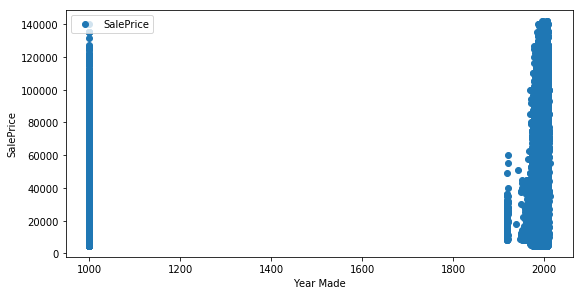

In [9]:
y_axis = dftrain.SalePrice
X_axis = dftrain.YearMade

fig, axs = plt.subplots(figsize = (20,10))

plt.subplot(221)
plt.scatter(X_axis, y_axis)
plt.xlabel("Year Made")
plt.ylabel("SalePrice")
plt.legend(loc='upper left')
plt.show()

###  Looks like we have funky values, we want to see how much of the total data is affected

In [10]:
# Looks like we have funky values, we want to see how much of the total data is affected
len(dftrain[dftrain.YearMade<1900]) / dftrain.shape[0]

# turns out it's 9.5% of our data

0.09519476472421315

In [11]:
median_year = dftrain['YearMade'].median()
median_year

1995.0

### We replace the weird values by the median

In [12]:
dftrain["YearMade"] = np.where(dftrain["YearMade"] == 1000, median_year, dftrain["YearMade"])

# another way: 
#condition = dftrain.YearMade > 1900
#median = dftrain.YearMade[condition].median()
#dftrain.ix[~condition, 'YearMade'] = median

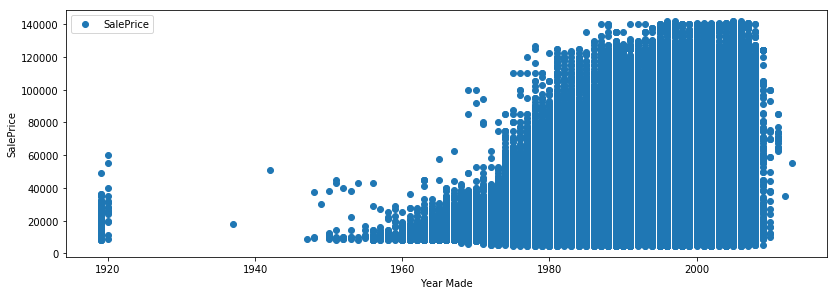

In [13]:
                                         ###### Year Made ######

y_axis = dftrain.SalePrice
X_axis = dftrain.YearMade

fig, axs = plt.subplots(figsize = (30,10))

plt.subplot(221)
plt.scatter(X_axis, y_axis)
plt.xlabel("Year Made")
plt.ylabel("SalePrice")
plt.legend(loc='upper left')
plt.show()

### inserting a column for the log_SalePrice

I had this later on (with the box plots), but then thought it could be useful for graphing so I moved it up

In [14]:
dftrain['log_SalePrice'] = np.log(dftrain['SalePrice'])

In [15]:
dftrain.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,saledate,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Enclosure,log_SalePrice
0,1139246,66000,999089,3157,121,3.0,2004.0,11/16/06 0:00,521D,521,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,EROPS w AC,11.097410
1,1139248,57000,117657,77,121,3.0,1996.0,3/26/04 0:00,950FII,950,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,EROPS w AC,10.950807
2,1139249,10000,434808,7009,121,3.0,2001.0,2/26/04 0:00,226,226,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,OROPS,9.210340
3,1139251,38500,1026470,332,121,3.0,2001.0,5/19/11 0:00,PC120-6E,PC120,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,EROPS w AC,10.558414
4,1139253,11000,1057373,17311,121,3.0,2007.0,7/23/09 0:00,S175,S175,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,EROPS,9.305651


### now I want to split the saledate to sale_day, sale_month,  sale_year - and append these three columns to the df (just like log_SalePrice)

In [16]:
#first let's see what it looks like
dftrain.saledate.head()

0    11/16/06 0:00
1     3/26/04 0:00
2     2/26/04 0:00
3     5/19/11 0:00
4     7/23/09 0:00
Name: saledate, dtype: object

In [34]:
#string splitting for month day and year
sale_date_parsed = dftrain['saledate'].str.replace(' ','/').str.split('/')

In [19]:
day_column = []
month_column = []
year_column = []

total_rows = sale_date_parsed.shape[0]

for i in range(total_rows):
    month_value = sale_date_parsed[i][0]
    month_column.append(float(month_value))
    
    day_value = sale_date_parsed[i][1]
    day_column.append(float(day_value))
    
    year_value = sale_date_parsed[i][2]
    year_column.append(float(year_value))
    

dftrain['sale_month'] = month_column
dftrain['sale_day'] = day_column
dftrain['sale_year'] = year_column

In [20]:
#Notice that sale_year is not in "199X or 20XX" form. This converts it
year_fullcolumn = []

for i in range(total_rows):
    year_value = sale_date_parsed[i][2]
    if float(year_value) > 80:
        full_year = "19" + year_value
    else:
        full_year = "20" + year_value
    year_fullcolumn.append(float(full_year))

dftrain['sale_fullyear'] = year_fullcolumn

In [21]:
dftrain.head()

# it worked!

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,saledate,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Enclosure,log_SalePrice,sale_month,sale_day,sale_year,sale_fullyear
0,1139246,66000,999089,3157,121,3.0,2004.0,11/16/06 0:00,521D,521,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,EROPS w AC,11.097410,11.0,16.0,6.0,2006.0
1,1139248,57000,117657,77,121,3.0,1996.0,3/26/04 0:00,950FII,950,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,EROPS w AC,10.950807,3.0,26.0,4.0,2004.0
2,1139249,10000,434808,7009,121,3.0,2001.0,2/26/04 0:00,226,226,Skid Steer Loader - 1351.0 to 1601.0 Lb Operat...,New York,SSL,Skid Steer Loaders,OROPS,9.210340,2.0,26.0,4.0,2004.0
3,1139251,38500,1026470,332,121,3.0,2001.0,5/19/11 0:00,PC120-6E,PC120,"Hydraulic Excavator, Track - 12.0 to 14.0 Metr...",Texas,TEX,Track Excavators,EROPS w AC,10.558414,5.0,19.0,11.0,2011.0
4,1139253,11000,1057373,17311,121,3.0,2007.0,7/23/09 0:00,S175,S175,Skid Steer Loader - 1601.0 to 1751.0 Lb Operat...,New York,SSL,Skid Steer Loaders,EROPS,9.305651,7.0,23.0,9.0,2009.0


In [22]:
dftrain.info()
#I went back and changed all the strings of date into floats so I can see the .describe information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401125 entries, 0 to 401124
Data columns (total 20 columns):
SalesID               401125 non-null int64
SalePrice             401125 non-null int64
MachineID             401125 non-null int64
ModelID               401125 non-null int64
datasource            401125 non-null int64
auctioneerID          380989 non-null float64
YearMade              401125 non-null float64
saledate              401125 non-null object
fiModelDesc           401125 non-null object
fiBaseModel           401125 non-null object
fiProductClassDesc    401125 non-null object
state                 401125 non-null object
ProductGroup          401125 non-null object
ProductGroupDesc      401125 non-null object
Enclosure             400800 non-null object
log_SalePrice         401125 non-null float64
sale_month            401125 non-null float64
sale_day              401125 non-null float64
sale_year             401125 non-null float64
sale_fullyear         401125 non-

In [23]:
dftrain.describe() # want to make sure there isn't anything funky in the year sold

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,log_SalePrice,sale_month,sale_day,sale_year,sale_fullyear
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1993.875692,10.103096,6.407035,16.110402,25.829103,2004.095728
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,9.218973,0.693621,3.424575,8.427322,36.654966,5.754190
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1919.000000,8.465900,1.000000,1.000000,0.000000,1989.000000
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1989.000000,9.581904,3.000000,9.000000,5.000000,2000.000000
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,10.085809,6.000000,16.000000,8.000000,2006.000000
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,10.596635,9.000000,23.000000,11.000000,2009.000000
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,11.863582,12.000000,31.000000,99.000000,2011.000000


How can we have a max of year made of 2013 but a max of year sold of 2011 if these are all records of sales?

In [24]:
dftrain[dftrain.YearMade == 2013]

#it's just one point, so I'm not going to worry about it...

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,saledate,fiModelDesc,fiBaseModel,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Enclosure,log_SalePrice,sale_month,sale_day,sale_year,sale_fullyear
395524,6275685,55000,156521,1453,149,1.0,2013.0,12/7/11 0:00,928GZ,928,Wheel Loader - 150.0 to 175.0 Horsepower,Georgia,WL,Wheel Loader,EROPS w AC,10.915088,12.0,7.0,11.0,2011.0


In [25]:
how_old = dftrain.sale_fullyear - dftrain.YearMade
dftrain['how_old'] = how_old

In [26]:
dftrain.describe()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,log_SalePrice,sale_month,sale_day,sale_year,sale_fullyear,how_old
count,4.011250e+05,401125.000000,4.011250e+05,401125.000000,401125.000000,380989.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000,401125.000000
mean,1.919713e+06,31099.712848,1.217903e+06,6889.702980,134.665810,6.556040,1993.875692,10.103096,6.407035,16.110402,25.829103,2004.095728,10.220036
std,9.090215e+05,23036.898502,4.409920e+05,6221.777842,8.962237,16.976779,9.218973,0.693621,3.424575,8.427322,36.654966,5.754190,7.344818
min,1.139246e+06,4750.000000,0.000000e+00,28.000000,121.000000,0.000000,1919.000000,8.465900,1.000000,1.000000,0.000000,1989.000000,-12.000000
25%,1.418371e+06,14500.000000,1.088697e+06,3259.000000,132.000000,1.000000,1989.000000,9.581904,3.000000,9.000000,5.000000,2000.000000,5.000000
50%,1.639422e+06,24000.000000,1.279490e+06,4604.000000,132.000000,2.000000,1995.000000,10.085809,6.000000,16.000000,8.000000,2006.000000,8.000000
75%,2.242707e+06,40000.000000,1.468067e+06,8724.000000,136.000000,4.000000,2000.000000,10.596635,9.000000,23.000000,11.000000,2009.000000,14.000000
max,6.333342e+06,142000.000000,2.486330e+06,37198.000000,172.000000,99.000000,2013.000000,11.863582,12.000000,31.000000,99.000000,2011.000000,92.000000


how do we have a -12 as min? I was only expecting the -2 for the funky one with 2013 year made and 2011 sold

In [27]:
dftrain[dftrain.how_old < 0].head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,saledate,fiModelDesc,fiBaseModel,...,state,ProductGroup,ProductGroupDesc,Enclosure,log_SalePrice,sale_month,sale_day,sale_year,sale_fullyear,how_old
24007,1236201,7500,1490105,6317,132,4.0,1995.0,2/11/94 0:00,311,311,...,Florida,TEX,Track Excavators,EROPS,8.922658,2.0,11.0,94.0,1994.0,-1.0
24015,1236338,10500,1494065,6345,132,1.0,1995.0,9/20/94 0:00,C166,C166,...,Texas,TEX,Track Excavators,EROPS,9.259131,9.0,20.0,94.0,1994.0,-1.0
24065,1236432,9000,1328819,6347,132,2.0,1995.0,3/25/94 0:00,C366,C366,...,New Jersey,TEX,Track Excavators,EROPS,9.104980,3.0,25.0,94.0,1994.0,-1.0
24073,1236445,12000,1078464,6347,132,99.0,1995.0,5/17/94 0:00,C366,C366,...,Oregon,TEX,Track Excavators,EROPS,9.392662,5.0,17.0,94.0,1994.0,-1.0
24082,1250090,21000,1163439,3051,132,1.0,1995.0,9/20/94 0:00,30B,30,...,Texas,TEX,Track Excavators,EROPS,9.952278,9.0,20.0,94.0,1994.0,-1.0


ah! it's the ones that we replaced the median of 1995 for... 

In [29]:
len(dftrain[dftrain.how_old < 0]) / len(dftrain)

0.001458398254908071

but it's not a big % of the data (0.01%)... though may be worthwhile going back and zero-ing them out later ~ 

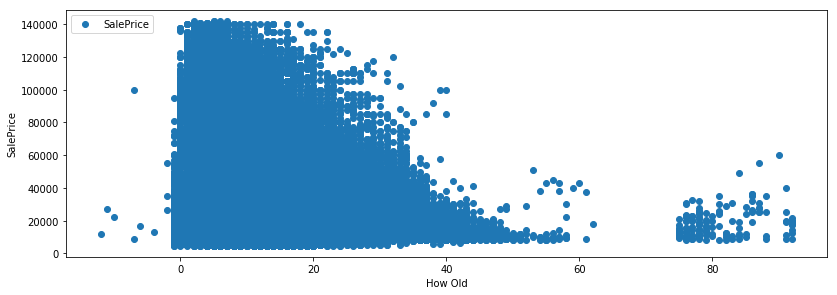

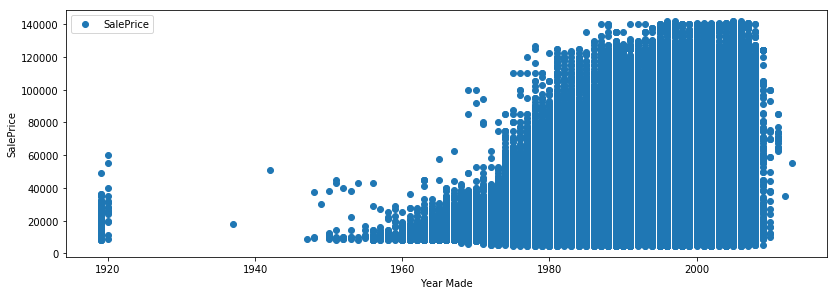

In [45]:
                                         ###### How Old ######

y_axis = dftrain.SalePrice
X_axis = dftrain.how_old

fig, axs = plt.subplots(figsize = (30,10))

plt.subplot(221)
plt.scatter(X_axis, y_axis)
plt.xlabel("How Old")
plt.ylabel("SalePrice")
plt.legend(loc='upper left')
plt.show()

y_axis = dftrain.SalePrice
X_axis = dftrain.YearMade

fig, axs = plt.subplots(figsize = (30,10))

plt.subplot(221)
plt.scatter(X_axis, y_axis)
plt.xlabel("Year Made")
plt.ylabel("SalePrice")
plt.legend(loc='upper left')
plt.show()

PLotted them together bc I think they're essentially telling the same story... 
but at least it was good string practice :)

### I don't think these next ones have any bearing... but we can take a look 
(graphs are in the earlier version)

In [30]:
product_group_price = dftrain.groupby('ProductGroupDesc')['SalePrice'].mean()
product_group_price.keys()

Index(['Backhoe Loaders', 'Motor Graders', 'Skid Steer Loaders',
       'Track Excavators', 'Track Type Tractors', 'Wheel Loader'],
      dtype='object', name='ProductGroupDesc')

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


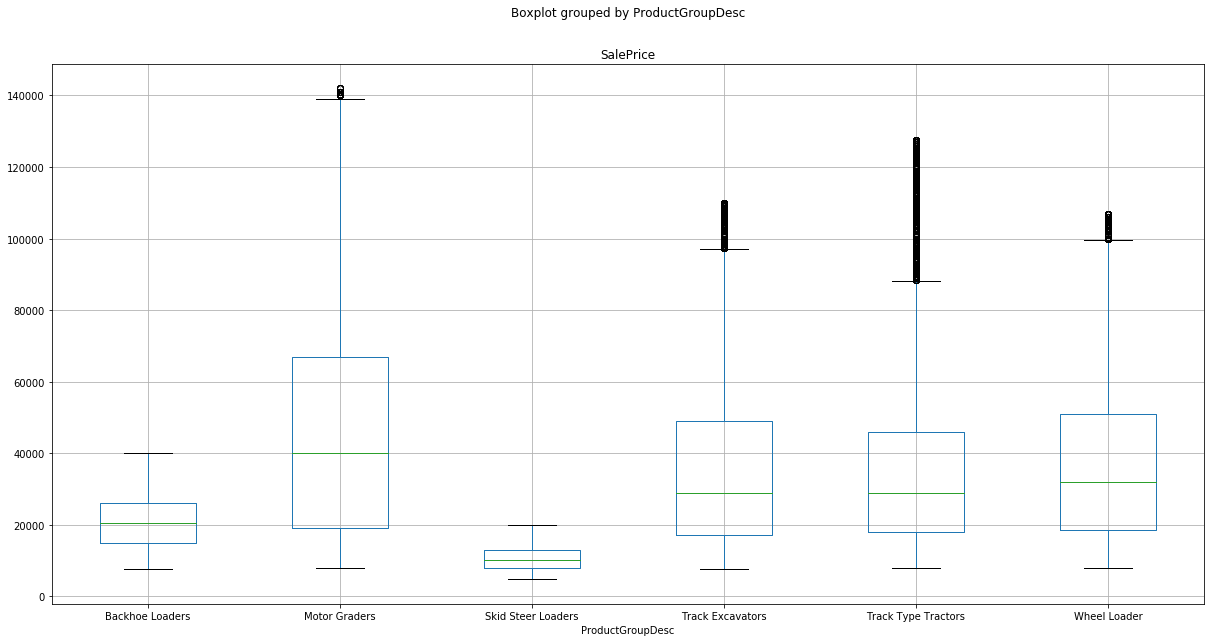

In [31]:
# since we have small number of ProductGroupDesc we can graph it as boxplot

dftrain.boxplot(column = 'SalePrice', by = 'ProductGroupDesc', figsize = (20,10))

In [32]:
product_group_price = dftrain.groupby('fiModelDesc')['SalePrice'].mean()
len(product_group_price)

# there's too many to plot this

4999

/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:57: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


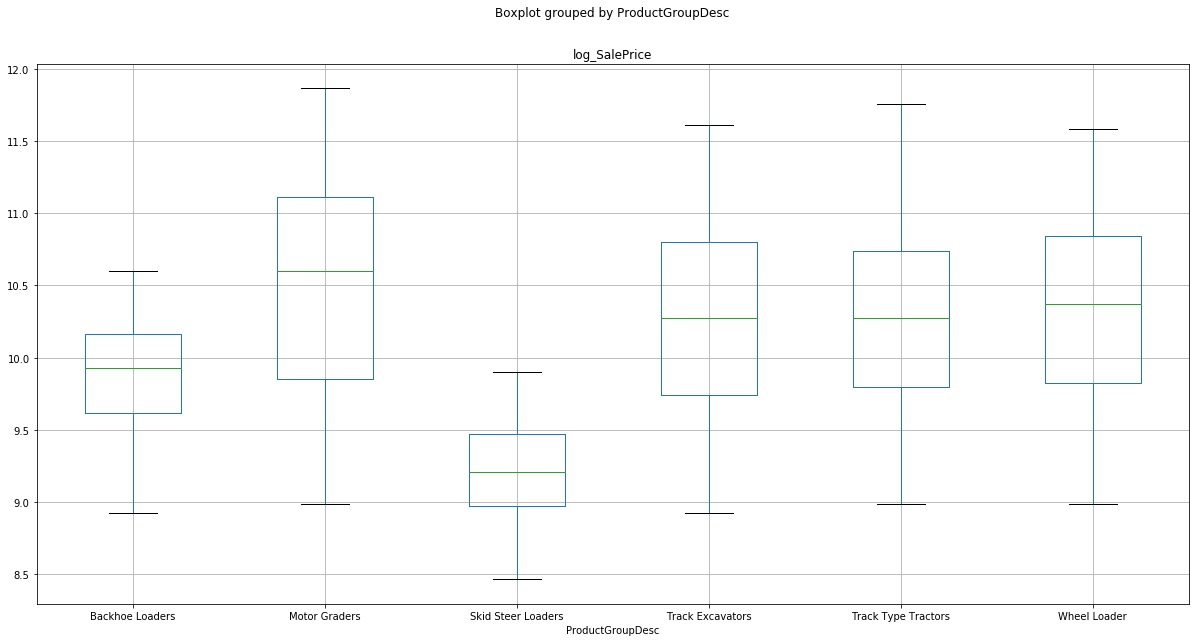

In [53]:
# now let's plot the logprice and see if anything changes
dftrain.boxplot(column = 'log_SalePrice', by = 'ProductGroupDesc', figsize = (20,10))

# Modeling brainstorming

probably useful:

- YearMade
- **ProductGroupDesc
- **Enclosure
- sale_month
- sale_day
- sale_year
- sale_fullyear
- how_old

'** need to make into dummy

probably not useful: 

- SalesID - identifier; already plotted and no trend
- SalePrice - identifier; already plotted and no trend
- MachineID - identifier; already plotted and no trend
- ModelID
- datasource 
- auctioneerID
- saledate (since we already have sale year)

could be added as v2 of the models: 

- state: if they're grouped into regions, the transformed into dummy variables, then this could work?
-- could also work with decision trees
- fiProductClassDesc: look into this (not in data dictionary)
- fiModelDesc - concatenation of other fields, and many of those fields are missing
- fiBaseModel

others:

- ProductGroup: same as ProductGroupDesc, except abbreviated
- log_SalePrice: we can't use this as a predictor bc it's what we're trying to predict...

# Data prep & train_test split

In [45]:
dftrain_model = dftrain[['YearMade', 'ProductGroupDesc','Enclosure','sale_month','sale_fullyear','how_old']] #note: you need both brackets
dftrain_model.head()

,YearMade,ProductGroupDesc,Enclosure,sale_month,sale_fullyear,how_old
0,2004.0,Wheel Loader,EROPS w AC,11.0,2006.0,2.0
1,1996.0,Wheel Loader,EROPS w AC,3.0,2004.0,8.0
2,2001.0,Skid Steer Loaders,OROPS,2.0,2004.0,3.0
3,2001.0,Track Excavators,EROPS w AC,5.0,2011.0,10.0
4,2007.0,Skid Steer Loaders,EROPS,7.0,2009.0,2.0


changing the categorical variables to boolean expansion

In [47]:
data = pd.get_dummies(dftrain_model)
data.head()

,YearMade,sale_month,sale_fullyear,how_old,ProductGroupDesc_Backhoe Loaders,ProductGroupDesc_Motor Graders,ProductGroupDesc_Skid Steer Loaders,ProductGroupDesc_Track Excavators,ProductGroupDesc_Track Type Tractors,ProductGroupDesc_Wheel Loader,Enclosure_EROPS,Enclosure_EROPS AC,Enclosure_EROPS w AC,Enclosure_NO ROPS,Enclosure_None or Unspecified,Enclosure_OROPS
0,2004.0,11.0,2006.0,2.0,0,0,0,0,0,1,0,0,1,0,0,0
1,1996.0,3.0,2004.0,8.0,0,0,0,0,0,1,0,0,1,0,0,0
2,2001.0,2.0,2004.0,3.0,0,0,1,0,0,0,0,0,0,0,0,1
3,2001.0,5.0,2011.0,10.0,0,0,0,1,0,0,0,0,1,0,0,0
4,2007.0,7.0,2009.0,2.0,0,0,1,0,0,0,1,0,0,0,0,0


In [51]:
target = dftrain[['SalePrice']]
target.shape

(401125, 1)

In [48]:
# checking to see if there are any missing values. Looks like there aren't
np.isnan(data).any()

YearMade                                False
sale_month                              False
sale_fullyear                           False
how_old                                 False
ProductGroupDesc_Backhoe Loaders        False
ProductGroupDesc_Motor Graders          False
ProductGroupDesc_Skid Steer Loaders     False
ProductGroupDesc_Track Excavators       False
ProductGroupDesc_Track Type Tractors    False
ProductGroupDesc_Wheel Loader           False
Enclosure_EROPS                         False
Enclosure_EROPS AC                      False
Enclosure_EROPS w AC                    False
Enclosure_NO ROPS                       False
Enclosure_None or Unspecified           False
Enclosure_OROPS                         False
dtype: bool

train test split

In [53]:
X_train, X_test, y_train, y_test = train_test_split(data,
                                                    target,
                                                    test_size = 0.2,
                                                    random_state = 42)

## Modeling

### Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
test_score = regressor.score(X_test, y_test) #R^2
training_score = regressor.score(X_train, y_train)

print('R^2 on test set for Linear Regression: ', test_score)
print('R^2 on training set for Linear Regression: ', training_score)

R^2 on test set for Linear Regression:  0.436380424098
R^2 on training set for Linear Regression:  0.439491110399


trying the **mean_squared_log_error** ... but I'm getting errors (ask Sean)

In [64]:
np.array(y_train)

array([[ 36500],
       [ 33500],
       [  8750],
       ..., 
       [ 26000],
       [100000],
       [ 31000]])

In [65]:
type(y_pred)

numpy.ndarray

In [66]:
type(y_train)

pandas.core.frame.DataFrame

In [59]:
np.isnan(y_pred).any()

False

In [67]:
from sklearn.metrics import mean_squared_log_error
# mean_squared_log_error(y_true, y_pred, sample_weight=None, multioutput=’uniform_average)

y_pred = regressor.predict(X_train)

mean_sqrlog_error = mean_squared_log_error(y_train, y_pred)
mean_sqrlog_error

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [69]:
y_pred[y_pred < 1]

# maybe that's what's through the error?

array([-14966.24799347,  -1858.6188736 ,   -885.98236847, ...,
         -401.83002472,  -6002.15424347,  -3148.09955597])

In [68]:
from sklearn.metrics import mean_squared_log_error
# mean_squared_log_error(y_true, y_pred, sample_weight=None, multioutput=’uniform_average)

y_series = regressor.predict(X_train)
Y_pred = np.array(y_series) #changing it to np array in case that's the problem

mean_sqrlog_error = mean_squared_log_error(y_train, y_pred)
mean_sqrlog_error

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/regression.py:314: RuntimeWarning: invalid value encountered in log
  return mean_squared_error(np.log(y_true + 1), np.log(y_pred + 1),


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Now I'm going to look at the average accuracy using **cross validation**

In [75]:
from sklearn.model_selection import cross_val_score

cross_score = cross_val_score(regressor, X_train, y_train, cv=10)
cross_score

array([ 0.43466022,  0.43889861,  0.44270432,  0.44459391,  0.44325954,
        0.439928  ,  0.43589795,  0.43843971,  0.43532917,  0.44044484])

In [76]:
# I think I was supposed to use the test data... but the scoring isn't that different
# Ask Sean
cross_test_score = cross_val_score(regressor, X_test, y_test, cv=10)
cross_test_score

array([ 0.42491564,  0.44301892,  0.44703587,  0.43028362,  0.44724881,
        0.4335059 ,  0.43044301,  0.43178206,  0.43712678,  0.43673283])

still pretty bad...

In [77]:
#cross_score_logerror = cross_val_score(regressor, X_train, y_train, cv=10, scoring = 'neg_mean_squared_log_error')
#cross_score_logerror

#check why this gives an error